# Assignment 1 - Clustering

### 1. Look at this Website:

https://rpubs.com/alanyang0924/TTE 

### 2. Extract the dummy data in the package and save it as "data_censored.csv"

In [2]:
import pandas as pd

data = pd.read_csv('data_censored.csv')

print(data)

   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   
5   1       5          1   0 -0.057482   0  0.734203   41  0.500000        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  
5         1         0  


### 3. Convert the R codes into Python Codes (use Jupyter Notebook), replicate the results using your python code.

#### 1. Setup

A sequence of target trials analysis starts by specifying which estimand will be used:
```R
trial_pp  <- trial_sequence(estimand = "PP")  # Per-protocol

trial_itt <- trial_sequence(estimand = "ITT") # Intention-to-treat
```

In [ ]:
# translated python:

Additionally it is useful to create a directory to save files for later inspection.
```R
trial_pp_dir  <- file.path(tempdir(), "trial_pp")
dir.create(trial_pp_dir)

trial_itt_dir <- file.path(tempdir(), "trial_itt")
dir.create(trial_itt_dir)
```

In [ ]:
# translated python:

#### 2. Data preparation

Next the user must specify the observational input data that will be used for the target trial emulation. Here we need to specify which columns contain which values and how they should be used.

```R
data("data_censored") # dummy data in the package
head(data_censored)

##   id period treatment x1           x2 x3       x4 age      age_s outcome
## 1  1      0         1  1  1.146148362  0 0.734203  36 0.08333333       0
## 2  1      1         1  1  0.002200337  0 0.734203  37 0.16666667       0
## 3  1      2         1  0 -0.481762418  0 0.734203  38 0.25000000       0
## 4  1      3         1  0  0.007872396  0 0.734203  39 0.33333333       0
## 5  1      4         1  1  0.216053715  0 0.734203  40 0.41666667       0
## 6  1      5         1  0 -0.057481504  0 0.734203  41 0.50000000       0
##   censored eligible
## 1        0        1
## 2        0        0
## 3        0        0
## 4        0        0
## 5        0        0
## 6        1        0
```

In [1]:
#translated python
import pandas as pd

data = pd.read_csv('data_censored.csv')

print(data)

   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   
5   1       5          1   0 -0.057482   0  0.734203   41  0.500000        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  
5         1         0  


```R
# Per-protocol
trial_pp <- trial_pp |>
  set_data(
    data      = data_censored,
    id        = "id",
    period    = "period",
    treatment = "treatment",
    outcome   = "outcome",
    eligible  = "eligible"
  )

# ITT
# Function style without pipes
trial_itt <- set_data( 
  trial_itt,
  data      = data_censored,
  id        = "id",
  period    = "period",
  treatment = "treatment",
  outcome   = "outcome",
  eligible  = "eligible"
)

## Trial Sequence Object 
## Estimand: Intention-to-treat 
##  
## Data: 
##  - N: 725 observations from 89 patients 
##         id period treatment    x1           x2    x3        x4   age      age_s
##      <int>  <int>     <num> <num>        <num> <int>     <num> <num>      <num>
##   1:     1      0         1     1  1.146148362     0 0.7342030    36 0.08333333
##   2:     1      1         1     1  0.002200337     0 0.7342030    37 0.16666667
##  ---                                                                           
## 724:    99      6         1     1 -0.033762356     1 0.5752681    71 3.00000000
## 725:    99      7         0     0 -1.340496520     1 0.5752681    72 3.08333333
##      outcome censored eligible time_on_regime
##        <num>    <int>    <num>          <num>
##   1:       0        0        1              0
##   2:       0        0        0              1
##  ---                                         
## 724:       0        0        0              1
## 725:       1        0        0              2
##  
## IPW for informative censoring: 
##  - No weight model specified 
##  
## Sequence of Trials Data: 
## - Use set_expansion_options() and expand_trials() to construct the sequence of trials dataset. 
##  
## Outcome model: 
##  - Outcome model not specified. Use set_outcome_model()
```

In [ ]:
# translated python:

#### 3. Weight models and censoring

To adjust for the effects of informative censoring, inverse probability of censoring weights (IPCW) can be applied. To estimate these weights, we construct time-to-(censoring) event models. Two sets of models are fit for the two censoring mechanisms which may apply: censoring due to deviation from assigned treatment and other informative censoring.

##### 3.1 Censoring due to treatment switching

We specify model formulas to be used for calculating the probability of receiving treatment in the current period. Separate models are fitted for patients who had treatment = 1 and those who had treatment = 0 in the previous period. Stabilized weights are used by fitting numerator and denominator models.

There are optional arguments to specify columns which can include/exclude observations from the treatment models. These are used in case it is not possible for a patient to deviate from a certain treatment assignment in that period.

```R
trial_pp <- trial_pp |>
  set_switch_weight_model(
    numerator    = ~ age,
    denominator  = ~ age + x1 + x3,
    model_fitter = stats_glm_logit(save_path = file.path(trial_pp_dir, "switch_models"))
  )
trial_pp@switch_weights

##  - Numerator formula: treatment ~ age 
##  - Denominator formula: treatment ~ age + x1 + x3 
##  - Model fitter type: te_stats_glm_logit 
##  - Weight models not fitted. Use calculate_weights()
```

This type of censoring is not used with an ITT estimand, so we cannot use `set_switch_weight_model()` with `trial_ITT` objects.

In [ ]:
# translated python:

##### 3.2 Other informative censoring

In case there is other informative censoring occurring in the data, we can create similar models to estimate the IPCW. These can be used with all types of estimand. We need to specify `censor_event` which is the column containing the censoring indicator.

```R
trial_pp <- trial_pp |>
  set_censor_weight_model(
    censor_event = "censored",
    numerator    = ~ x2,
    denominator  = ~ x2 + x1,
    pool_models  = "none",
    model_fitter = stats_glm_logit(save_path = file.path(trial_pp_dir, "switch_models"))
  )
trial_pp@censor_weights

##  - Numerator formula: 1 - censored ~ x2 
##  - Denominator formula: 1 - censored ~ x2 + x1 
##  - Model fitter type: te_stats_glm_logit 
##  - Weight models not fitted. Use calculate_weights()
```

In [ ]:
# translated python:

```R
trial_itt <- set_censor_weight_model(
  trial_itt,
  censor_event = "censored",
  numerator    = ~x2,
  denominator  = ~ x2 + x1,
  pool_models  = "numerator",
  model_fitter = stats_glm_logit(save_path = file.path(trial_itt_dir, "switch_models"))
)
trial_itt@censor_weights

##  - Numerator formula: 1 - censored ~ x2 
##  - Denominator formula: 1 - censored ~ x2 + x1 
##  - Numerator model is pooled across treatment arms. Denominator model is not pooled. 
##  - Model fitter type: te_stats_glm_logit 
##  - Weight models not fitted. Use calculate_weights()
```

In [ ]:
# translated python:

#### 4. Calculate Weights

Next we need to fit the individual models and combine them into weights. This is done with `calculate_weights()`.

```R
trial_pp  <- trial_pp |> calculate_weights()
trial_itt <- calculate_weights(trial_itt)
```

In [ ]:
# translated python:

The full model objects are saved to disk in the directories we created above. The summaries are stored in the trial sequence object and can be printed:

```R
show_weight_models

## Weight Models for Informative Censoring
## ---------------------------------------
## 
## [[n]]
## Model: P(censor_event = 0 | X) for numerator 
##  
##  term        estimate   std.error statistic p.value     
##  (Intercept)  2.4480907 0.1405726 17.415128 6.334656e-68
##  x2          -0.4486482 0.1368765 -3.277759 1.046346e-03
##  
##  null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs
##  404.2156      724     -196.7002 397.4004 406.5727 393.4004 723         725 
##  
##  path                                                                                              
##  C:\\Users\\14379\\AppData\\Local\\Temp\\RtmpoDhrya/trial_itt/switch_models\\model_29e85584264c.rds
##  
## [[d0]]
## Model: P(censor_event = 0 | X, previous treatment = 0) for denominator 
##  
##  term        estimate   std.error statistic p.value     
##  (Intercept)  1.8941961 0.2071122  9.145746 5.921948e-20
##  x2          -0.5898292 0.1693402 -3.483101 4.956409e-04
##  x1           0.8552603 0.3452930  2.476912 1.325247e-02
##  
##  null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs
##  283.0723      425     -132.1655 270.3309 282.4943 264.3309 423         426 
##  
##  path                                                                                             
##  C:\\Users\\14379\\AppData\\Local\\Temp\\RtmpoDhrya/trial_itt/switch_models\\model_29e84d26c13.rds
##  
## [[d1]]
## Model: P(censor_event = 0 | X, previous treatment = 1) for denominator 
##  
##  term        estimate    std.error statistic  p.value     
##  (Intercept)  2.81443372 0.3122688  9.0128570 2.007570e-19
##  x2          -0.03713196 0.2699579 -0.1375472 8.905983e-01
##  x1           0.89351418 0.7771954  1.1496648 2.502819e-01
##  
##  null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs
##  113.0528      298     -55.72938 117.4588 128.5601 111.4588 296         299 
##  
##  path                                                                                             
##  C:\\Users\\14379\\AppData\\Local\\Temp\\RtmpoDhrya/trial_itt/switch_models\\model_29e8d844487.rds
## 
```

In [ ]:
# translated python:

```R
show_weight_models(trial_pp)


##  term        estimate    std.error  statistic  p.value   
##  (Intercept)  1.55485166 0.81706997  1.9029602 0.05704573
##  age         -0.02312027 0.01696843 -1.3625460 0.17302562
##  x1           0.52915871 0.43594855  1.2138100 0.22482028
##  x3           0.21319587 0.35744378  0.5964459 0.55087740
##  
##  null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs
##  188.829       150     -92.54787 193.0957 205.1649 185.0957 147         151 
##  
##  path                                                                                             
##  C:\\Users\\14379\\AppData\\Local\\Temp\\RtmpoDhrya/trial_pp/switch_models\\model_29e8365f2ffb.rds
##  
## [[n0]]
## Model: P(treatment = 1 | previous treatment = 0) for numerator 
##  
##  term        estimate    std.error  statistic p.value   
##  (Intercept)  1.09212298 0.60582678  1.802698 0.07143559
##  age         -0.03360404 0.01439482 -2.334453 0.01957201
##  
##  null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs
##  232.2705      169     -113.2746 230.5492 236.8208 226.5492 168         170 
##  
##  path                                                                                             
##  C:\\Users\\14379\\AppData\\Local\\Temp\\RtmpoDhrya/trial_pp/switch_models\\model_29e86b1816e0.rds
##  
## [[d0]]
## Model: P(treatment = 1 | previous treatment = 0) for denominator 
##  
##  term        estimate    std.error  statistic  p.value   
##  (Intercept)  1.03084683 0.63052714  1.6348969 0.10207067
##  age         -0.03633255 0.01472576 -2.4672779 0.01361446
##  x1           0.64473751 0.32346837  1.9932011 0.04623943
##  x3          -0.23411026 0.32147930 -0.7282281 0.46647397
##  
##  null.deviance df.null logLik  AIC    BIC      deviance df.residual nobs
##  232.2705      169     -111.03 230.06 242.6032 222.06   166         170 
##  
##  path                                                                                             
##  C:\\Users\\14379\\AppData\\Local\\Temp\\RtmpoDhrya/trial_pp/switch_models\\model_29e83d5c48dd.rds
## 
```

In [ ]:
# translated python:

#### 5. Specify Outcome Model

Now we can specify the outcome model. Here we can include adjustment terms for any variables in the dataset. The numerator terms from the stabilised weight models are automatically included in the outcome model formula.

```R
trial_pp  <- set_outcome_model(trial_pp)
trial_itt <- set_outcome_model(trial_itt, adjustment_terms = ~x2)
```

In [ ]:
# translated python:

#### 6. Expand Trials


Now we are ready to create the data set with all of the sequence of target trials.

```R
trial_pp <- set_expansion_options(
  trial_pp,
  output     = save_to_datatable(),
  chunk_size = 500 # the number of patients to include in each expansion iteration
)
trial_itt <- set_expansion_options(
  trial_itt,
  output     = save_to_datatable(),
  chunk_size = 500
)
```

In [ ]:
# translated python:

##### 6.1 Create Sequence of Trials Data

```R
trial_pp  <- expand_trials(trial_pp)
trial_itt <- expand_trials(trial_itt)

trial_pp@expansion
## Sequence of Trials Data: 
## - Chunk size: 500 
## - Censor at switch: TRUE 
## - First period: 0 | Last period: Inf 
##  
## A TE Datastore Datatable object 
## N: 500 observations 
##         id trial_period followup_time outcome    weight treatment         x2
##      <int>        <int>         <int>   <num>     <num>     <num>      <num>
##   1:     1            0             0       0 1.0000000         1  1.1461484
##   2:     1            0             1       0 0.8951447         1  1.1461484
##  ---                                                                        
## 499:    99            0             0       0 1.0000000         1 -0.3463778
## 500:    99            0             1       0 1.0122336         1 -0.3463778
##        age assigned_treatment
##      <num>              <num>
##   1:    36                  1
##   2:    36                  1
##  ---                         
## 499:    65                  1
## 500:    65                  1
```

In [ ]:
# Translated python: 

#### 7. Load or Sample from Expanded Data

Now that the expanded data has been created, we can prepare the data to fit the outcome model. For data that can fit comfortably in memory, this is a trivial step using `load_expanded_data`.

For large datasets, it may be necessary to sample from the expanded by setting the `p_control` argument. This sets the probability that an observation with `outcome == 0` will be included in the loaded data. A seed can be set for reproducibility. Additionally, a vector of periods to include can be specified, e.g., `period = 1:60`, and/or a subsetting condition, `subset_condition = "age > 65"`.

```R
trial_itt <- load_expanded_data(trial_itt, seed = 1234, p_control = 0.5)
```

In [ ]:
# translated python:

#### 8. Fit Marginal Structural Model

To fit the outcome model we use `fit_msm()`.

```R
trial_itt <- fit_msm(
  trial_itt,
  weight_cols    = c("weight", "sample_weight"),
  modify_weights = function(w) { # winsorization of extreme weights
    q99 <- quantile(w, probs = 0.99)
    pmin(w, q99)
  }
)
```

Model Summary:
```R
trial_itt@outcome_model
## - Formula: outcome ~ assigned_treatment + x2 + followup_time + I(followup_time^2) + trial_period + I(trial_period^2) 
## - Treatment variable: assigned_treatment 
## - Adjustment variables: x2 
## - Model fitter type: te_stats_glm_logit 
##  
## Model Summary: 
##  
##  term               estimate std.error statistic p.value conf.low conf.high
##  (Intercept)        -6.02    0.780      -7.72    1.2e-14 -7.550   -4.4916  
##  assigned_treatment  1.63    0.496       3.28    1.0e-03  0.654    2.5977  
##  x2                  0.31    0.418       0.74    4.6e-01 -0.511    1.1282  
##  followup_time       0.34    0.244       1.38    1.7e-01 -0.141    0.8148  
##  I(followup_time^2) -0.02    0.014      -1.42    1.5e-01 -0.049    0.0077  
##  trial_period        7.29    0.978       7.45    9.1e-14  5.371    9.2040  
##  I(trial_period^2)  -7.68    0.537     -14.31    1.8e-46 -8.737   -6.6325  
##  
##  null.deviance df.null logLik AIC BIC deviance df.residual nobs
##  158           800     -69.1  152 185 135      794         801
```

In [ ]:
# Translated python:

Depending on the model fitter used, we can also access the model object. For the default `stats::glm` logistic model, we have the `glm` object as well as the `sandwich` variance-covariance matrix.

```R
trial_itt@outcome_model@fitted@model$model

## 
## Call:  glm(formula = formula, family = binomial("logit"), data = data, 
##     weights = weights, x = FALSE, y = FALSE)
## 
## Coefficients:
##        (Intercept)  assigned_treatment                  x2       followup_time  
##           -6.02067             1.62585             0.30837             0.33673  
## I(followup_time^2)        trial_period   I(trial_period^2)  
##           -0.02049             7.28762            -7.68478  
## 
## Degrees of Freedom: 800 Total (i.e. Null);  794 Residual
## Null Deviance:       157.8 
## Residual Deviance: 134.7     AIC: 152.2

trial_itt@outcome_model@fitted@model$vcov

##                     (Intercept) assigned_treatment           x2 followup_time
## (Intercept)         0.608651263       -0.007606479  0.042942422  -0.143451214
## assigned_treatment -0.007606479        0.245882729  0.087953406  -0.052364376
## x2                  0.042942422        0.087953406  0.174977954  -0.045052691
## followup_time      -0.143451214       -0.052364376 -0.045052691   0.059487800
## I(followup_time^2)  0.007130666        0.002815736  0.002843807  -0.003362158
## trial_period       -0.105885453       -0.341609248 -0.097440741   0.104454026
## I(trial_period^2)   0.049055893        0.165009684  0.046219048  -0.054969078
##                    I(followup_time^2) trial_period I(trial_period^2)
## (Intercept)              0.0071306658  -0.10588545        0.04905589
## assigned_treatment       0.0028157357  -0.34160925        0.16500968
## x2                       0.0028438066  -0.09744074        0.04621905
## followup_time           -0.0033621580   0.10445403       -0.05496908
## I(followup_time^2)       0.0002067028  -0.00514379        0.00265172
## trial_period            -0.0051437905   0.95604134       -0.51334414
## I(trial_period^2)        0.0026517200  -0.51328532        0.28822666
```

In [ ]:
# Translated python:

The complete object shows all the specifications:

```R
trial_itt

## Trial Sequence Object 
## Estimand: Intention-to-treat 
##  
## Data: 
##  - N: 725 observations from 89 patients 
##         id period treatment    x1           x2    x3        x4   age      age_s
##      <int>  <int>     <num> <num>        <num> <int>     <num> <num>      <num>
##   1:     1      0         1     1  1.146148362     0 0.7342030    36 0.08333333
##   2:     1      1         1     1  0.002200337     0 0.7342030    37 0.16666667
##  ---                                                                           
## 724:    99      6         1     1 -0.033762356     1 0.5752681    71 3.00000000
## 725:    99      7         0     0 -1.340496520     1 0.5752681    72 3.08333333
##      outcome censored eligible time_on_regime        wt       wtC
##        <num>    <int>    <num>          <num>     <num>     <num>
##   1:       0        0        1              0 0.9835463 0.9835463
##   2:       0        0        0              1 0.9429254 0.9429254
##  ---                                                             
## 724:       0        0        0              1 0.9440988 0.9440988
## 725:       1        0        0              2 1.0092093 1.0092093
##  
## IPW for informative censoring: 
##  - Numerator formula: 1 - censored ~ x2 
##  - Denominator formula: 1 - censored ~ x2 + x1 
##  - Numerator model is pooled across treatment arms. Denominator model is not pooled. 
##  - Model fitter type: te_stats_glm_logit 
##  - View weight model summaries with show_weight_models() 
##  
## Sequence of Trials Data: 
## - Chunk size: 500 
## - Censor at switch: FALSE 
## - First period: 0 | Last period: Inf 
##  
## A TE Datastore Datatable object 
## N: 1558 observations 
##          id trial_period followup_time outcome    weight treatment         x2
##       <int>        <int>         <int>   <num>     <num>     <num>      <num>
##    1:     1            0             0       0 1.0000000         1  1.1461484
##    2:     1            0             1       0 0.9429254         1  1.1461484
##   ---                                                                        
## 1557:    99            0             6       0 0.8917236         1 -0.3463778
## 1558:    99            0             7       1 0.8999358         0 -0.3463778
##       assigned_treatment
##                    <num>
##    1:                  1
##    2:                  1
##   ---                   
## 1557:                  1
## 1558:                  1
##  
## Outcome model: 
## - Formula: outcome ~ assigned_treatment + x2 + followup_time + I(followup_time^2) + trial_period + I(trial_period^2) 
## - Treatment variable: assigned_treatment 
## - Adjustment variables: x2 
## - Model fitter type: te_stats_glm_logit 
##  
## Model Summary: 
##  
##  term               estimate std.error statistic p.value conf.low conf.high
##  (Intercept)        -6.02    0.780      -7.72    1.2e-14 -7.550   -4.4916  
##  assigned_treatment  1.63    0.496       3.28    1.0e-03  0.654    2.5977  
##  x2                  0.31    0.418       0.74    4.6e-01 -0.511    1.1282  
##  followup_time       0.34    0.244       1.38    1.7e-01 -0.141    0.8148  
##  I(followup_time^2) -0.02    0.014      -1.42    1.5e-01 -0.049    0.0077  
##  trial_period        7.29    0.978       7.45    9.1e-14  5.371    9.2040  
##  I(trial_period^2)  -7.68    0.537     -14.31    1.8e-46 -8.737   -6.6325  
##  
##  null.deviance df.null logLik AIC BIC deviance df.residual nobs
##  158           800     -69.1  152 185 135      794         801 
##  
## Outcome data 
## N: 801 observations from 76 patients in 18 trial periods 
## Periods: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
## Sampling control observations with probability: 0.5 
##         id trial_period followup_time outcome   weight treatment         x2
##      <int>        <int>         <int>   <num>    <num>     <num>      <num>
##   1:    15            0             0       1 1.000000         1 -0.7365256
##   2:    32            0             0       1 1.000000         1  1.9861380
##  ---                                                                       
## 800:    39            0            19       0 1.351756         1  0.2189413
## 801:    54            0            19       0 1.359294         0  1.2924128
##      assigned_treatment sample_weight        w
##                   <num>         <num>    <num>
##   1:                  1             1 1.000000
##   2:                  1             1 1.000000
##  ---                                          
## 800:                  1             2 2.703512
## 801:                  0             2 2.718587
```

In [ ]:
# Translated python:

#### 9. Inference

We use the `predict()` method to estimate survival probabilities or cumulative incidences for different values of `assigned_treatment`.

```R
preds <- predict(
  trial_itt,
  newdata       = outcome_data(trial_itt)[trial_period == 1, ],
  predict_times = 0:10,
  type          = "survival",
)

plot(preds$difference$followup_time, preds$difference$survival_diff,
  type = "l", xlab = "Follow up", ylab = "Survival difference")
lines(preds$difference$followup_time, preds$difference$`2.5%`, type = "l", col = "red", lty = 2)
lines(preds$difference$followup_time, preds$difference$`97.5%`, type = "l", col = "red", lty = 2)
```

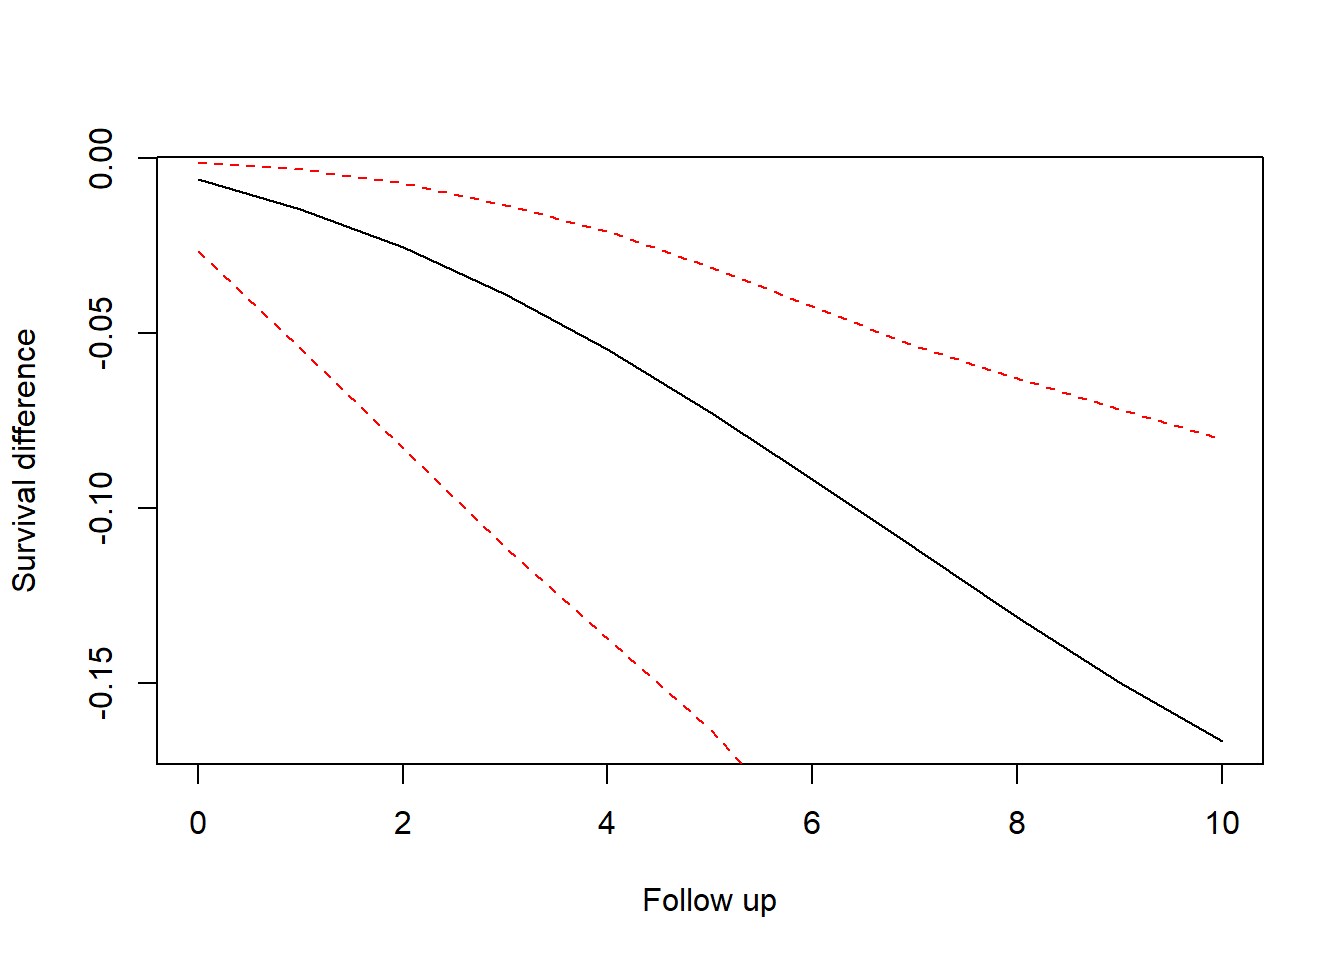

In [ ]:
# Translated python: